### Acrobot Problema

Este problema pone a prueba un algoritmo de aprendizaje por refuerzo. Se considera resuelta si el objetivo principal se logra continuamente durante 100 episodios.

El objetivo se ha alcanzado cuando la altura del extremo del segundo enlace es igual o superior a la línea de meta. Esta línea de meta se encuentra a una distancia del origen (el centro del primer enlace del Acrobot) que es igual al doble de la longitud de los enlaces del Acrobot. La altura en cualquier estado se calcula de la siguiente forma:

$altura = -cos(\theta_1) - cos(\theta_2 + \theta_1)$

Donde $\theta_1$ y $\theta_2$ son los ángulos de los enlaces con respecto a la vertical.

El episodio se acaba cuando:

1. Terminación: El extremo libre alcanza la altura objetivo, que se construye como: -cos(theta1) - cos(theta2 + theta1) > threshold (1 o 0)

2. Truncamiento: la duración del episodio es superior a 500 (200 para v0)


Los espacios de acción son 3:

1. Acción 0: Aplicar un torque negativo en el eje que une los dos enlaces.
2. Acción 1: No aplicar ningún torque.
3. Acción 2: Aplicar un torque positivo en el eje que une los dos enlaces.

Los estados de observación es un array de 6 elementos:


1.   $cos(\theta_1)$: El coseno del primer ángulo de articulación.
2.   $sen(\theta_1)$: El seno del primer ángulo de articulación.
3.   $cos(\theta_2)$: El coseno del segundo ángulo de articulación.
4.   $sen(\theta_2)$: El seno del segundo ángulo de articulación.
5.   $\omega_1$: La velocidad angular del primer enlace.
6.   $\omega_2$: La velocidad angular del segundo enlace.




El algoritmo propuesto para resolver este problema es la DQN. La cuál es la unión de redes neuronales con el algoritmo Q-learning. Este se implementa a continuación.

![Arquitectura propuesta](https://github.com/djsg2021utec/proyecto2_incertidumbre/blob/main/Proyecto.jpg?raw=true)



In [12]:

import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import random
import matplotlib.pyplot as plt
from IPython import display
from collections import defaultdict
import time


class Net(nn.Module):
    def __init__(self, obs_space, action_space):
        super(Net, self).__init__()
        # Capas de la arquitectura
        self.fc1 = nn.Linear(obs_space, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, action_space)

    def forward(self, x):
        # Funciones de activación
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DQN:
    def __init__(self, obs_space, action_space):
        self.eps = 0.4 #Parámetro epsilon variable en la estrategia de exploración-explotación 0.4 de probabilidad de exploración y 0.6 de explotación
        self.eps_min = 0.1 #El valor mínimo que debe tener el épsilon
        self.eps_decay = 0.995 #Velocidad de decaimiento del épsilon
        self.gamma = 0.99 #Parámetro de descuento que se utiliza en la actualización del valor de las acciones
        self.batch_size = 64 # Tamaño del lote de datos de entrenamiento que se usa para cada actualización del modelo
        self.alpha = 0.001 # Velocidad de aprendizaje
        self.memory = deque(maxlen=2000) # Cola(tamaño) donde guarda la fracción de la selección aleatoria de un lote de experiencias que usará para aprender de ellas
        self.action_space = action_space # Espacio de acciones
        self.net = Net(obs_space, action_space) #Red de evaluación
        self.target_net = Net(obs_space, action_space) #Red objetivo
        self.target_net.load_state_dict(self.net.state_dict()) #Sincronización de la red de evaluación con la objetivo
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.alpha) #Optimizador para minimizar la función de pérdida
        self.loss_fn = nn.MSELoss()  # Función de pérdida

    def get_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self.net(state) #Devolverá los valores Q estimados para cada acción posible.
        if np.random.rand() > self.eps:
          #Si el número aleatorio es mayor el agente elige la acción que tiene el valor Q más alto (explotación)
            action = torch.argmax(q_values).item()
        else:
          #Si el número aleatorio es menor o igual que epsilon el agente elige una acción aleatoria del espacio de acciones (exploración)
            action = np.random.choice(self.action_space)
        return action
    def get_height(self, state):
        theta1 = np.arccos(state[0])  # cos(theta1)
        theta2 = np.arccos(state[2])  # cos(theta2)
        return -np.cos(theta1) - np.cos(theta1 + theta2)

    def update(self, state, action, reward, next_state, done):
      # Guarda la experiencia más reciente en la memoria del agente en una tupla
        self.memory.append((state, action, reward, next_state, done))
      # Reduce el valor de epsilon si el episodio ha terminado, pero no lo deja caer por debajo de eps_min
        if done: self.eps = max(self.eps*self.eps_decay, self.eps_min)
      # Comprueba si hay suficientes experiencias en la memoria para formar un lote
        if len(self.memory) < self.batch_size: return
      # Selecciona un lote de experiencias de la memoria del agente.
        batch = random.sample(self.memory, self.batch_size)
      # Convertir listas de estados, acciones, recompensas, siguientes estados y flags de terminación en tensores
        state, action, reward, next_state, done = zip(*batch)
        state = torch.tensor(state, dtype=torch.float32)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float32)
        next_state = torch.tensor(next_state, dtype=torch.float32)
        done = torch.tensor(done, dtype=torch.float32)

      # Parte de la ecuación bellman
      ## 1. Se calculan los valores Q actuales para las acciones tomadas en los estados del lote.
        curr_q = self.net(state).gather(1, action.unsqueeze(1)).squeeze(1)
      ## 2. Se calculan los valores Q máximos para los estados siguientes utilizando la red objetivo.
        next_q = self.target_net(next_state).max(1)[0]
      ## 3. Se calculan los valores Q esperados a partir de las recompensas y los valores Q de los estados siguientes.
        expected_q = reward + self.gamma * next_q * (1-done)
      ## 4. Se calcula la pérdida como la diferencia entre los valores Q actuales y los esperados.
        loss = self.loss_fn(curr_q, expected_q.detach())

      ## Backward y actualización de pesos
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    # Para actualizar la red objetivo
    def update_target(self):
        self.target_net.load_state_dict(self.net.state_dict())


# Se inicializa el ambiente
env = gym.make('Acrobot-v1')
# Se crea el agente
agent = DQN(env.observation_space.shape[0], env.action_space.n)
# Se define el número de episodios
episodes = 250

# Se crean las listas donde se guardarán los valores del tiempo, etapas, alturas máximas y recompensas
time_per_episode = []
steps_per_episode = []
max_height_per_episode = []
rewards_per_episode = []


for episode in range(episodes):

    start_time = time.time()
    state = env.reset()
    done = False
    total_reward = 0
    max_height=-2
    while (not done):
        if total_reward < -499:
          break

######## Descomentar si desea ver el render de cada etapa en cada episodio (Ctrl + Shift + L + /) #########################
        # env.render()  # Render the environment for visualisation
        # img = plt.imshow(env.render(mode='rgb_array'))
        # img.set_data(env.render(mode='rgb_array')) # Sólo actualiza los datos que estás mostrando.

        # plt.axis('off')
        # display.display(plt.gcf())
        # display.clear_output(wait=True)
###################################################################################################

        action = agent.get_action(state)
        height = agent.get_height(state)

        if max_height < height:
          max_height = height
        if height>=0:
          break

        next_state, reward, done, info = env.step(action)
        agent.update(state, action, reward, next_state, done)
        state = next_state

        # Acumular la recompensa
        total_reward += reward

    if episode % 10 == 0:
        agent.update_target()
    end_time = time.time()
    time_episode = end_time - start_time
    print('Episodio:', episode, '| Tiempo:', time_episode, '| Etapas:', int(abs(total_reward)), '| Recompensa acumulada:', total_reward, '| Altura máxima: ', max_height)

    # Guarda la recompensa total de este episodio
    rewards_per_episode.append(total_reward)
    # Guarda el tiempo de ejecución del episodio
    time_per_episode.append(time_episode)
    # Guarda el número de etapas del episodio
    steps_per_episode.append(abs(total_reward))
    # Guarda la altura máxima por episodio
    max_height_per_episode.append(max_height)

# Cerrar el ambiente después de que el entrenamiento está completo.
env.close()

Episodio: 0 | Tiempo: 1.6982488632202148 | Etapas: 175 | Recompensa acumulada: -175.0 | Altura máxima:  0.014703095
Episodio: 1 | Tiempo: 2.0570240020751953 | Etapas: 500 | Recompensa acumulada: -500.0 | Altura máxima:  -1.3553027
Episodio: 2 | Tiempo: 1.8915855884552002 | Etapas: 500 | Recompensa acumulada: -500.0 | Altura máxima:  -1.674444
Episodio: 3 | Tiempo: 1.8799641132354736 | Etapas: 500 | Recompensa acumulada: -500.0 | Altura máxima:  -1.4411769
Episodio: 4 | Tiempo: 1.8446998596191406 | Etapas: 500 | Recompensa acumulada: -500.0 | Altura máxima:  -0.94160706
Episodio: 5 | Tiempo: 1.856229543685913 | Etapas: 500 | Recompensa acumulada: -500.0 | Altura máxima:  -1.3327568
Episodio: 6 | Tiempo: 2.8503854274749756 | Etapas: 500 | Recompensa acumulada: -500.0 | Altura máxima:  -1.2663989
Episodio: 7 | Tiempo: 4.315525054931641 | Etapas: 500 | Recompensa acumulada: -500.0 | Altura máxima:  -1.0780705
Episodio: 8 | Tiempo: 2.5000827312469482 | Etapas: 407 | Recompensa acumulada: -4

# Evaluación necesaria:
1. Duración (steps y tiempo) por Episodio (atrás). Promedio de varias ejecuciones.
2. Máxima Altura alcanzada por episodio (atrás). Promedio de varias ejecuciones.
3. Reward alcanzado por episodio (atrás). Promedio de varias ejecuciones.


In [19]:
# Duración promedio
print ("Duración (s) promedio: ",sum(time_per_episode)/len(time_per_episode)," segundos")
print ("Máxima altura promedio: ",sum(max_height_per_episode)/len(max_height_per_episode)," metros")
print ("Recompensa promedio: ",sum(rewards_per_episode)/len(rewards_per_episode))

Duración (s) promedio:  0.6370075616836548  segundos
Máxima altura promedio:  0.059612037777900695  metros
Recompensa promedio:  -127.46


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Gráficos

1. Duración (etapas y tiempo) por episodio
2. Máxima altura alcanzada por episodio

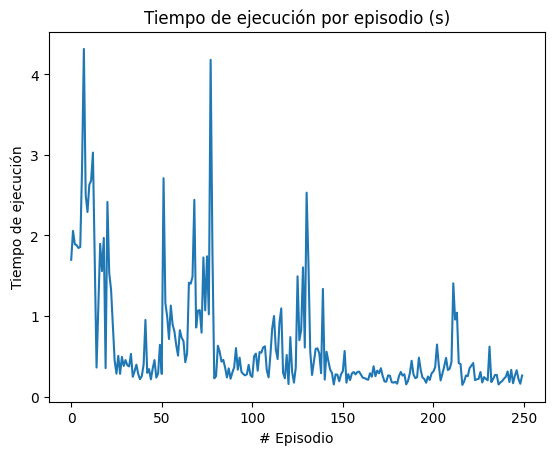

In [13]:
    plt.plot(time_per_episode)
    plt.title('Tiempo de ejecución por episodio (s)')
    plt.xlabel('# Episodio')
    plt.ylabel('Tiempo de ejecución')
    plt.show()

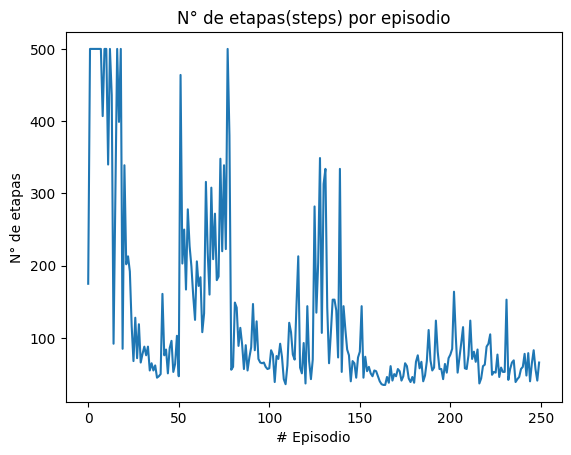

In [14]:

    plt.plot(steps_per_episode)
    plt.title('N° de etapas(steps) por episodio')
    plt.xlabel('# Episodio')
    plt.ylabel('N° de etapas')
    plt.show()


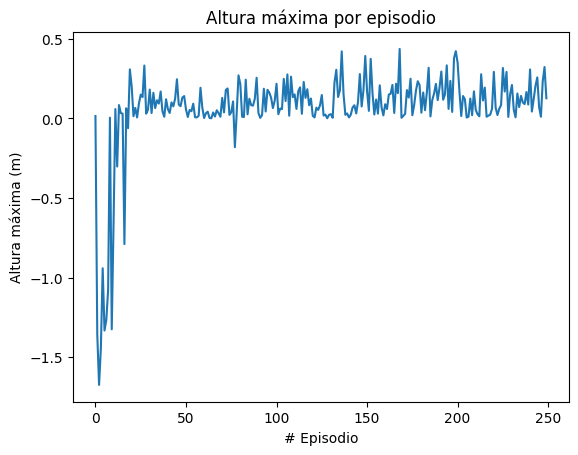

In [15]:
    plt.plot(max_height_per_episode)
    plt.title('Altura máxima por episodio')
    plt.xlabel('# Episodio')
    plt.ylabel('Altura máxima (m)')
    plt.show()


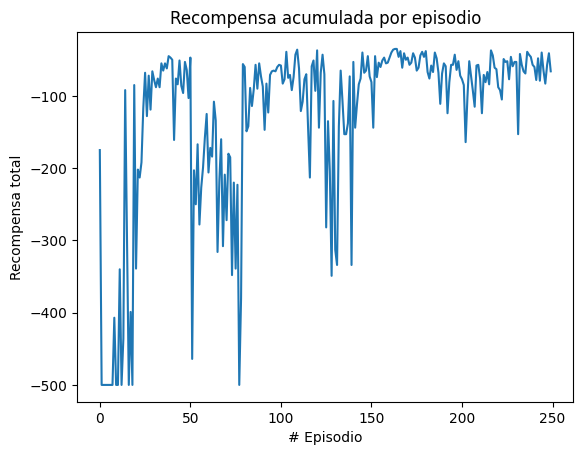

In [16]:
    plt.plot(rewards_per_episode)
    plt.title('Recompensa acumulada por episodio')
    plt.xlabel('# Episodio')
    plt.ylabel('Recompensa total')
    plt.show()